In [13]:
from enum import Enum
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import torch


# define notebook mode
class Mode(Enum):
    t = 'train'
    p = 'predict'


# 创建数据库引擎
table_hk_daily = "hk_customs_sum_daily"
table_hk_monthly = "hk_customs_sum_monthly"
table_sh_monthly = "sh_customs"
table_hk_selected = "hk_customs_daily_selected"
database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)

# define hyper paras
use_standard_scaler = True
mode = Mode.p
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = 'saits_hk_imputation_20240222235322.pypots'

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

query = f"SELECT * FROM {table_hk_selected}"
df = pd.read_sql_query(query, engine)

# save original df
df_reindex = df.copy()
df_reindex_scaled = df.copy()

# use scalar
scaler = MinMaxScaler()
if use_standard_scaler:
    for column in df_reindex_scaled.columns:
        if column not in ['date']:
            df_reindex_scaled[column] = scaler.fit_transform(df_reindex_scaled[column].values.reshape(-1, 1)).reshape(
                -1)

# make a date range
date_range = pd.date_range(start=df_reindex_scaled['date'].min(), end=df_reindex_scaled['date'].max())

# 重建索引，填充缺失的日期
df_reindex_scaled['date'] = pd.to_datetime(df_reindex_scaled['date'])
df_reindex_scaled.set_index('date', inplace=True)  # 设置日期列为索引
df_reindex_scaled = df_reindex_scaled.reindex(date_range).rename_axis('date').reset_index()

# do same thing to df
df_reindex['date'] = pd.to_datetime(df_reindex['date'])
df_reindex.set_index('date', inplace=True)  # 设置日期列为索引
df_reindex = df_reindex.reindex(date_range).rename_axis('date').reset_index()

# # 筛选出不在该日期区间的列
# start_date = '2020-1-24'
# end_date = '2023-04-01'
# df = df[(df['date'] < start_date) | (df['date'] > end_date)]

num_samples = df_reindex_scaled.values.shape[0]
num_features = df_reindex_scaled.values.shape[1] - 1  # 减去date

In [15]:
df_reindex_scaled

,date,CN_airport_entry,global_airport_entry,CN_airport_departure,global_airport_departure
0,2019-04-04,0.507932,1.000000,0.459227,0.615084
1,2019-04-05,0.507055,0.869103,0.392493,0.633795
2,2019-04-06,0.388645,0.789448,0.488273,0.728679
3,2019-04-07,0.455647,0.687925,0.638289,0.954568
4,2019-04-08,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1778,2024-02-15,0.595288,0.379137,0.578769,0.351601
1779,2024-02-16,0.597077,0.388598,0.575258,0.319038
1780,2024-02-17,0.453858,0.334998,0.517590,0.348709
1781,2024-02-18,0.321744,0.326499,0.483876,0.403193


In [16]:
from pygrinder import mcar

X = df_reindex_scaled.drop(columns=['date']).values  # drop date column
X = X.reshape(1, num_samples, -1)
X_ori = X  # keep X_ori for validation

X = mcar(X, 0.1)  # randomly hold out 10% observed values as ground truth
dataset = {"X": X}  # X for model input
print(X.shape)  # (11988, 48, 37), 11988 samples, 48 time steps, 37 features

(1, 1783, 4)


In [17]:
import torch
from pypots.imputation import SAITS

# Model training. This is PyPOTS showtime.
if mode is Mode.t:
    saits = SAITS(n_steps=num_samples, n_features=4, n_layers=4, d_model=128, d_inner=128, n_heads=4, d_k=32, d_v=64,
                  dropout=0.1, epochs=100, device=device)
    saits.fit(dataset)
elif mode is Mode.p:
    pass  # predicting mode passing the training step

In [18]:
import torch
from pygrinder.utils import fill_and_get_mask_torch

if mode == Mode.p:
    model = torch.load(f'../models/{model_name}')
    model.eval()
    _X, missing_mask = fill_and_get_mask_torch(torch.Tensor(X))
    inputs = {
        "X": _X,
        "X_ori": _X,
        "indicating_mask": np.isnan(X) & np.isnan(X_ori),
        "missing_mask": missing_mask,
    }
    for k in inputs:
        inputs[k] = torch.Tensor(inputs[k]).to(device)
    with torch.no_grad():
        imputation = model(inputs)
        imputation = imputation['imputed_data'].cpu().detach().numpy()
else:
    imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values

imputation

array([[[0.50793225, 1.        , 0.45922697, 0.6150843 ],
        [0.44045553, 0.86910266, 0.39249346, 0.6337951 ],
        [0.3886451 , 0.78944755, 0.4882734 , 0.72867924],
        ...,
        [0.4538581 , 0.33499798, 0.51758987, 0.34870875],
        [0.3217444 , 0.32649896, 0.48387593, 0.4031927 ],
        [0.52477556, 0.42966592, 0.40661162, 0.27776974]]], dtype=float32)

In [19]:
from pypots.utils.metrics import calc_mae

indicating_mask = np.isnan(X) & np.isnan(X_ori)  # indicating mask for imputation error calculation
indicating_mask0 = indicating_mask.reshape(num_samples, num_features)[:, 0]

mae = calc_mae(imputation, np.nan_to_num(X_ori),
               indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)
mae

0.36573396951188203

In [20]:
import datetime

# save model and add date for tag
if mode is Mode.t:
    saits.save(saving_path=f"../models/saits_hk_imputation_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}",
               overwrite=False)

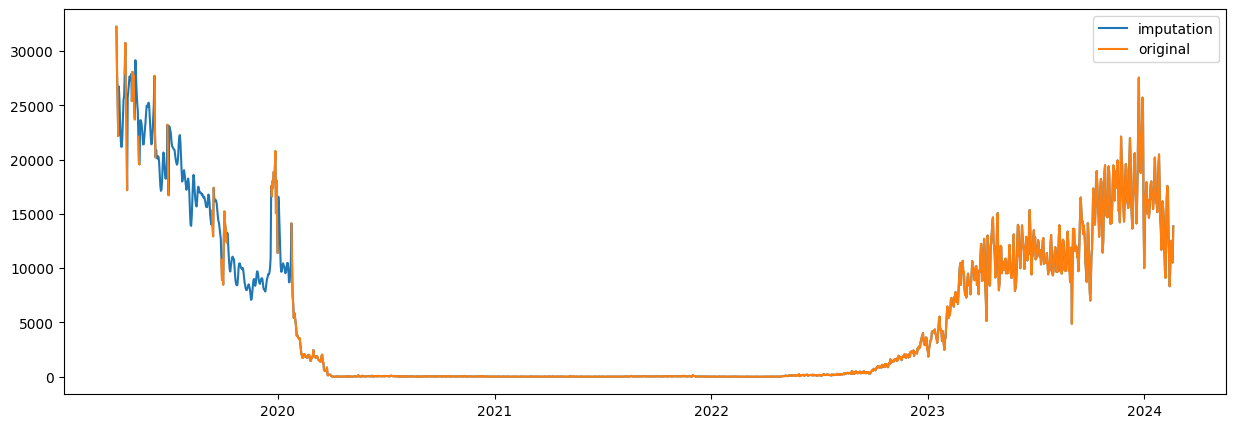

In [25]:
from matplotlib import pyplot as plt

# float to int
if use_standard_scaler:
    imputation_val = pd.DataFrame(scaler.inverse_transform(imputation.reshape(num_samples, 4)).astype('int'), columns=df.columns[1:])
    imputation_val['date'] = df_reindex['date']
else:
    imputation_val = pd.DataFrame(imputation.reshape(num_samples, 4).astype('int'), columns=df.columns[1:])
    imputation_val['date'] = df_reindex['date']

imputation_val = pd.DataFrame({
    col: np.where(indicating_mask0, imputation_val[col], df_reindex[col]) for col
    in
    df_reindex.columns
})

# revert data and draw
plt.figure(figsize=(15, 5))
plt.plot(imputation_val['date'], imputation_val['global_airport_entry'], label='imputation')
plt.plot(df_reindex['date'], df_reindex['global_airport_entry'], label='original')
plt.legend()
plt.show()

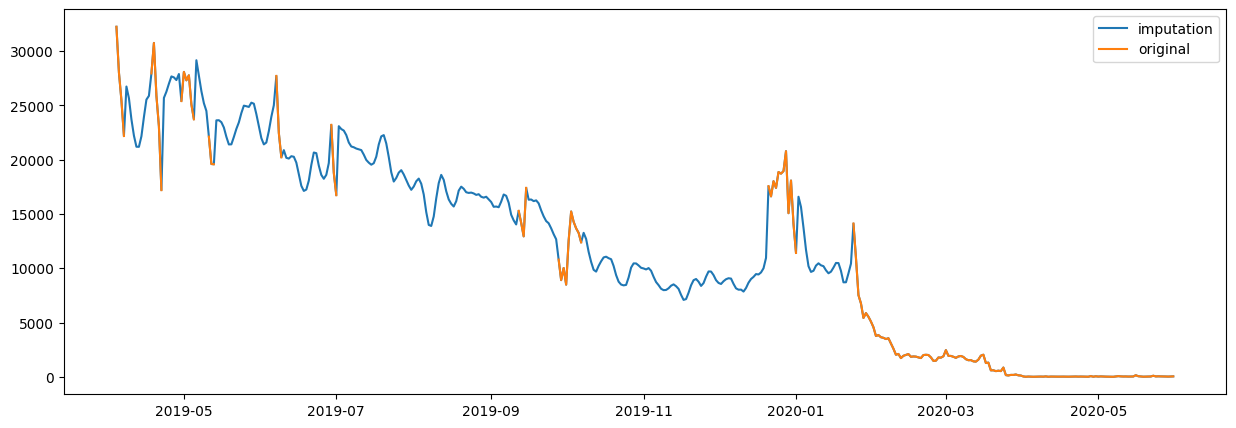

In [26]:
start_date = '2019-01-01'
end_date = '2020-06-01'
imputation_val_1 = imputation_val[(imputation_val['date'] > start_date) & (imputation_val['date'] < end_date)]
original_val_1 = df_reindex[(df_reindex['date'] > start_date) & (df_reindex['date'] < end_date)]

plt.figure(figsize=(15, 5))
plt.plot(imputation_val_1['date'], imputation_val_1['global_airport_entry'], label='imputation')
plt.plot(original_val_1['date'], original_val_1['global_airport_entry'], label='original')
plt.legend()
plt.show()

# perfect result

# Move data into Database

In [27]:
imputation_val

,date,CN_airport_entry,global_airport_entry,CN_airport_departure,global_airport_departure
0,2019-04-04,15048.0,32239.0,11905.0,21276.0
1,2019-04-05,15022.0,28019.0,10175.0,21923.0
2,2019-04-06,11514.0,25451.0,12658.0,25204.0
3,2019-04-07,13499.0,22178.0,16547.0,33015.0
4,2019-04-08,16549.0,26735.0,17173.0,21686.0
...,...,...,...,...,...
1778,2024-02-15,17636.0,12223.0,15004.0,12165.0
1779,2024-02-16,17689.0,12528.0,14913.0,11039.0
1780,2024-02-17,13446.0,10800.0,13418.0,12065.0
1781,2024-02-18,9532.0,10526.0,12544.0,13949.0


In [28]:
imputation_val.to_sql('hk_customs_daily_imputed', con=engine, if_exists='replace', index=False)

1783